In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion
from src.python.helpers import load_simulated_rt_data, mask_inputs
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.visualization import plot_calibration_curve

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, mean_absolute_error
from functools import partial
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Validation

## Load in data

In [2]:
levy_sims_folder = 'c:\\Users\\lasse\\documents\\hierarchical model comparison project\\data\\Levy_flight_application'

val_indices_900_filename = "val_indices_900_trials.npy"
val_datasets_900_filename = "val_datasets_900_trials.npy"

val_indices_900, val_datasets_900 = load_simulated_rt_data(levy_sims_folder, val_indices_900_filename, val_datasets_900_filename)

# Split validation datasets into 2 parts so that GPU does not blow up during prediction
val_datasets_900_1 = val_datasets_900[:4000,:,:,:]
val_datasets_900_2 = val_datasets_900[4000:8000,:,:,:]

In [3]:
# TODO: Test validation for different amounts of missing values
# 0%, 3.17% (-> as in data, missings_mean=28.5), 10% (-> missings_mean=90), 20% (-> missings_mean=180)?

# Apply masking to validation data if desired
mask_val_data = True

if mask_val_data:
    val_datasets_900_1 = mask_inputs(val_datasets_900_1, missings_mean=28.5, missings_sd=13.5)
    val_datasets_900_2 = mask_inputs(val_datasets_900_2, missings_mean=28.5, missings_sd=13.5)

## Load in trained network

In [4]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'trial_2'
checkpoint_path = os.path.join(os.getcwd(), 'training_checkpoints', trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\03_levy_flight_application\training_checkpoints\trial_2\ckpt-64


## Predict

In [5]:
# Predict
probs_900_1 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_1, 500)], axis=0).numpy()
probs_900_2 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_2, 500)], axis=0).numpy()
probs_900 = tf.concat([probs_900_1, probs_900_2], axis=0).numpy()

In [6]:
# Transform predictions and indices
rounded_predictions_900 = tf.one_hot(tf.argmax(probs_900, axis=1), depth=4)
rounded_predictions_flat_900 = tf.argmax(probs_900, axis=1)
true_models_flat_900 = tf.argmax(val_indices_900, axis=1)

In [7]:
# Export predictions
export_predictions = False

if export_predictions:
    local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
    filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_predictions_finetuned_900_robust')
    val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Levy_flight_application')

    np.save(os.path.join(val_folder, filename), probs_900)

In [8]:
# Load in predictions
load_predictions = False

if load_predictions:
    val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Levy_flight_application')
    filename = "2022_04_12___16_32_predictions_finetuned_900_robust.npy"
    probs_900 = np.load(os.path.join(val_folder, filename))

### Results

In [9]:
# Accuracy & MAE
accuracy = tf.reduce_sum(tf.cast(rounded_predictions_flat_900 == true_models_flat_900, tf.float32))/len(true_models_flat_900)
mae = mean_absolute_error(val_indices_900, probs_900)
print('Accuracy = {}, MAE = {}'.format(accuracy, mae))

Accuracy = 0.859375, MAE = 0.10065828263759613


Text(23.499999999999993, 0.5, 'True underlying model')

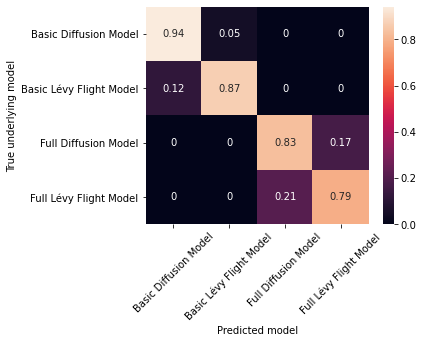

In [10]:
# Confusion matrix 

cm = confusion_matrix(true_models_flat_900, rounded_predictions_flat_900)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm.round(2)

labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)
plt.xticks(rotation=45)
plt.xlabel('Predicted model')
plt.ylabel('True underlying model')
#plt.savefig('Diffusion_conf_matrix.png', dpi=300, bbox_inches='tight')

ECE = 0.019
ECE = 0.020
ECE = 0.026
ECE = 0.026


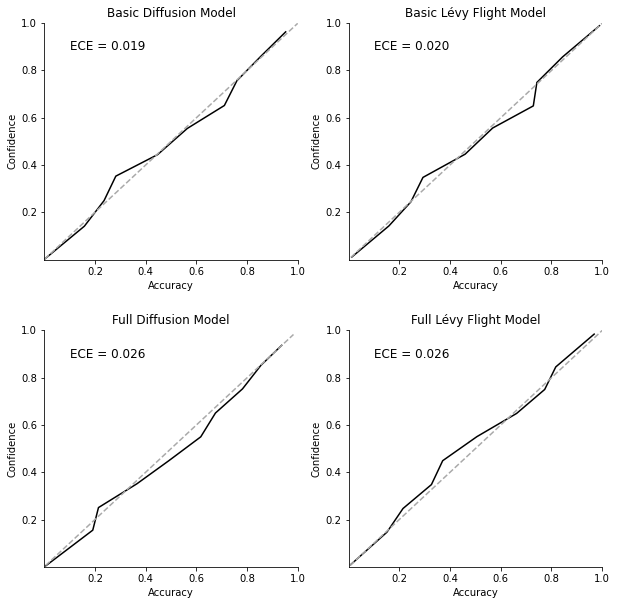

In [11]:
# Calibration curves

fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
n_cal_bins = 15
plt.subplots_adjust(hspace = .3)
pos1 = [0,0,1,1]
pos2 = [0,1,0,1]
labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]

for m in range(4):
    m_true = val_indices_900[:,m]
    m_soft = probs_900[:,m]
    plot_calibration_curve(m_true, m_soft, 10, pub_style=True, ax=axarr[pos1[m], pos2[m]],
                             title=labels[m], show_ece=True)
    

In [12]:
probs_900[:20]

array([[0.3929517 , 0.604244  , 0.00140217, 0.00140217],
       [0.92176294, 0.0729794 , 0.00262884, 0.00262884],
       [0.60096407, 0.39422756, 0.00240421, 0.00240421],
       [0.97850597, 0.01871652, 0.00138876, 0.00138876],
       [0.2733172 , 0.72215545, 0.00226368, 0.00226368],
       [0.6253477 , 0.18734   , 0.18455604, 0.00275631],
       [0.97348225, 0.02286342, 0.00182716, 0.00182716],
       [0.88448584, 0.11106569, 0.00222426, 0.00222426],
       [0.9373227 , 0.06015023, 0.00126354, 0.00126354],
       [0.9861257 , 0.01142861, 0.00122285, 0.00122285],
       [0.61153907, 0.38530847, 0.00157623, 0.00157623],
       [0.97148615, 0.02650683, 0.00100351, 0.00100351],
       [0.99786794, 0.00071068, 0.00071068, 0.00071068],
       [0.6959928 , 0.30204448, 0.00098135, 0.00098135],
       [0.9323947 , 0.06434542, 0.00162995, 0.00162995],
       [0.5909731 , 0.4045221 , 0.00225243, 0.00225243],
       [0.63287336, 0.3633279 , 0.00189935, 0.00189935],
       [0.9835    , 0.01491671,

In [13]:
probs_900[probs_900[:,3] > 0.90, :][:20]

array([[0.00100769, 0.00100769, 0.00100769, 0.9969769 ],
       [0.00161939, 0.00161939, 0.00251258, 0.9942486 ],
       [0.0016125 , 0.0016125 , 0.04386128, 0.95291376],
       [0.00129839, 0.00129839, 0.08159824, 0.915805  ],
       [0.00165727, 0.00165727, 0.00165727, 0.9950282 ],
       [0.0013359 , 0.0013359 , 0.08106115, 0.91626704],
       [0.0017433 , 0.0017433 , 0.07870208, 0.91781133],
       [0.00134138, 0.00134138, 0.00134139, 0.99597585],
       [0.00181051, 0.00181051, 0.00211099, 0.994268  ],
       [0.00144572, 0.00144572, 0.08068892, 0.9164197 ],
       [0.00120768, 0.00120768, 0.05593766, 0.941647  ],
       [0.00164669, 0.00164669, 0.017549  , 0.9791576 ],
       [0.00146498, 0.00146498, 0.03471331, 0.96235675],
       [0.00195755, 0.00195755, 0.09432758, 0.90175736],
       [0.00176812, 0.00176812, 0.09309155, 0.9033722 ],
       [0.00144055, 0.00144055, 0.00205392, 0.995065  ],
       [0.00108454, 0.00108454, 0.07345285, 0.9243781 ],
       [0.00102309, 0.00102309,

In [14]:
uniques_per_row = [len(np.unique(probs_900[row,:])) for row in range(probs_900.shape[0])]

# Percentual occurence of different numbers of unique predictions
[[x,uniques_per_row.count(x)/8000] for x in [1,2,3,4]]

[[1, 0.0], [2, 0.230625], [3, 0.747875], [4, 0.0215]]